In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [13]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# base_dir = '/home/camaro/Desktop/CODEBASE/cat_dog/cats_and_dogs_small'
base_dir = '/home/camaro/Desktop/CODEBASE/pneumonia/chest_xray/chest_xray'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 624)
test_features, test_labels = extract_features(test_dir, 16)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (624, 4 * 4 * 512))
test_features = np.reshape(test_features, (16, 4 * 4 * 512))

In [15]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 624 samples
Epoch 1/100
2000/2000 [==============================] - 1s 269us/step - loss: 0.4509 - acc: 0.7895 - val_loss: 0.5136 - val_acc: 0.6747
Epoch 2/100
2000/2000 [==============================] - 0s 207us/step - loss: 0.2629 - acc: 0.9005 - val_loss: 0.5466 - val_acc: 0.6923
Epoch 3/100
2000/2000 [==============================] - 0s 214us/step - loss: 0.2000 - acc: 0.9235 - val_loss: 0.5360 - val_acc: 0.7228
Epoch 4/100
2000/2000 [==============================] - 0s 213us/step - loss: 0.1680 - acc: 0.9385 - val_loss: 0.4611 - val_acc: 0.7708
Epoch 5/100
2000/2000 [==============================] - 0s 209us/step - loss: 0.1538 - acc: 0.9435 - val_loss: 0.4662 - val_acc: 0.7821
Epoch 6/100
2000/2000 [==============================] - 0s 214us/step - loss: 0.1389 - acc: 0.9545 - val_loss: 0.4584 - val_acc: 0.7917
Epoch 7/100
2000/2000 [==============================] - 0s 216us/step - loss: 0.1289 - acc: 0.9550 - val_loss: 0.5447 - val_acc: 0

2000/2000 [==============================] - 0s 217us/step - loss: 0.0353 - acc: 0.9875 - val_loss: 0.8792 - val_acc: 0.7580
Epoch 61/100
2000/2000 [==============================] - 0s 210us/step - loss: 0.0341 - acc: 0.9915 - val_loss: 0.6998 - val_acc: 0.7997
Epoch 62/100
2000/2000 [==============================] - 0s 210us/step - loss: 0.0336 - acc: 0.9885 - val_loss: 0.7283 - val_acc: 0.7917
Epoch 63/100
2000/2000 [==============================] - 0s 211us/step - loss: 0.0316 - acc: 0.9905 - val_loss: 0.9041 - val_acc: 0.7580
Epoch 64/100
2000/2000 [==============================] - 0s 212us/step - loss: 0.0311 - acc: 0.9900 - val_loss: 0.8456 - val_acc: 0.7692
Epoch 65/100
2000/2000 [==============================] - 0s 207us/step - loss: 0.0315 - acc: 0.9895 - val_loss: 0.8233 - val_acc: 0.7756
Epoch 66/100
2000/2000 [==============================] - 0s 206us/step - loss: 0.0311 - acc: 0.9905 - val_loss: 0.8768 - val_acc: 0.7660
Epoch 67/100
2000/2000 [=======================

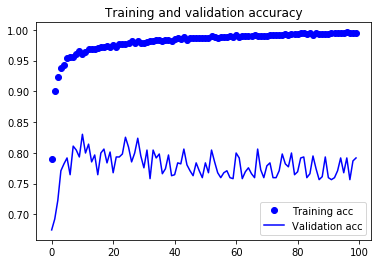

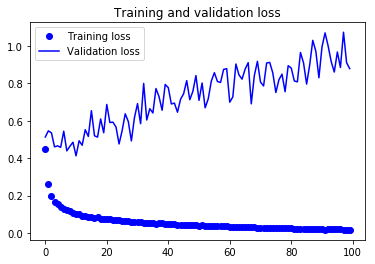

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [19]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [20]:
conv_base.trainable = False

In [21]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/30
 - 27s - loss: 0.4399 - acc: 0.7775 - val_loss: 0.4776 - val_acc: 0.7226
Epoch 2/30
 - 25s - loss: 0.3243 - acc: 0.8580 - val_loss: 0.3884 - val_acc: 0.8415
Epoch 3/30
 - 25s - loss: 0.2755 - acc: 0.8836 - val_loss: 0.3540 - val_acc: 0.8638
Epoch 4/30
 - 25s - loss: 0.2522 - acc: 0.8900 - val_loss: 0.3552 - val_acc: 0.8608
Epoch 5/30
 - 25s - loss: 0.2405 - acc: 0.8945 - val_loss: 0.3486 - val_acc: 0.8618
Epoch 6/30
 - 25s - loss: 0.2223 - acc: 0.9174 - val_loss: 0.3153 - val_acc: 0.8811
Epoch 7/30
 - 26s - loss: 0.2121 - acc: 0.9125 - val_loss: 0.2962 - val_acc: 0.8831
Epoch 8/30
 - 26s - loss: 0.1991 - acc: 0.9230 - val_loss: 0.3032 - val_acc: 0.8862
Epoch 9/30
 - 26s - loss: 0.2071 - acc: 0.9150 - val_loss: 0.3320 - val_acc: 0.8689
Epoch 10/30
 - 26s - loss: 0.1969 - acc: 0.9229 - val_loss: 0.2988 - val_acc: 0.8841
Epoch 11/30
 - 26s - loss: 0.1959 - acc: 0.9195 - val_loss: 0.3114 - val_acc

In [23]:
model.save('pneumonia_finetunevgg.h5')

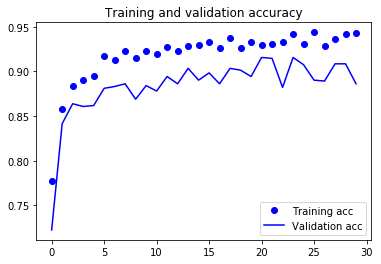

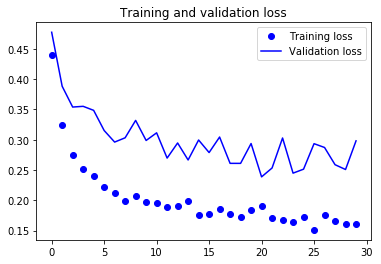

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [26]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 26s 263ms/step - loss: 0.1749 - acc: 0.9335 - val_loss: 0.3099 - val_acc: 0.8852
Epoch 2/100
100/100 [==============================] - 25s 252ms/step - loss: 0.1552 - acc: 0.9399 - val_loss: 0.2242 - val_acc: 0.9126
Epoch 3/100
100/100 [==============================] - 27s 267ms/step - loss: 0.1525 - acc: 0.9425 - val_loss: 0.2252 - val_acc: 0.9116
Epoch 4/100
100/100 [==============================] - 26s 261ms/step - loss: 0.1399 - acc: 0.9525 - val_loss: 0.2829 - val_acc: 0.9055
Epoch 5/100
100/100 [==============================] - 26s 257ms/step - loss: 0.1522 - acc: 0.9440 - val_loss: 0.2450 - val_acc: 0.9136
Epoch 6/100
100/100 [==============================] - 25s 249ms/step - loss: 0.1302 - acc: 0.9460 - val_loss: 0.2944 - val_acc: 0.9065
Epoch 7/100
100/100 [==============================] - 25s 253ms/step - loss: 0.1364 - acc: 0.9505 - val_loss: 0.2819 - val_acc: 0.9014
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 26s 263ms/step - loss: 0.0641 - acc: 0.9795 - val_loss: 0.2872 - val_acc: 0.9238
Epoch 62/100
100/100 [==============================] - 25s 251ms/step - loss: 0.0658 - acc: 0.9765 - val_loss: 0.2817 - val_acc: 0.9268
Epoch 63/100
100/100 [==============================] - 25s 252ms/step - loss: 0.0552 - acc: 0.9815 - val_loss: 0.3289 - val_acc: 0.9258
Epoch 64/100
100/100 [==============================] - 24s 245ms/step - loss: 0.0674 - acc: 0.9735 - val_loss: 0.3381 - val_acc: 0.9116
Epoch 65/100
100/100 [==============================] - 25s 246ms/step - loss: 0.0704 - acc: 0.9750 - val_loss: 0.2457 - val_acc: 0.9289
Epoch 66/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0739 - acc: 0.9758 - val_loss: 0.2564 - val_acc: 0.9370
Epoch 67/100
100/100 [==============================] - 25s 250ms/step - loss: 0.0576 - acc: 0.9755 - val_loss: 0.2871 - val_acc: 0.9248
Epoch 68/100
100/100 [===================

In [28]:
model.save('pneumonia_finetunevgg_final.h5')